In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize
import random
from sklearn.preprocessing import StandardScaler



In [39]:
# Extract CSV
import zipfile

zip_file_path = "recipes_with_final_embeddings.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall() 

csv_file_path = "recipes_with_final_embeddings.csv"  
recipes_df = pd.read_csv(csv_file_path)

bert_embeddings = np.load("bert_embeddings.npz")
bert_embeddings = bert_embeddings['embeddings']
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]


In [40]:
recipes_df = pd.read_csv("recipes_with_final_embeddings.csv")  
bert_embeddings = np.load("bert_embeddings.npz")
bert_embeddings = bert_embeddings['embeddings']
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]  

In [59]:
class CustomAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CustomAutoencoder, self).__init__()
        self.input_noise = layers.GaussianNoise(0.1)  
        self.encoder_dense1 = layers.Dense(latent_dim, activation='relu')
        self.encoder_dense2 = layers.Dense(512, activation='relu')
        self.encoder_latent = layers.Dense(latent_dim, activation='relu')
        self.latent_noise = layers.GaussianNoise(0.1)  
        self.decoder_dense1 = layers.Dense(512, activation='relu')
        self.decoder_dense2 = layers.Dense(1024, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        # Encoder
        x = self.input_noise(inputs)  
        x = self.encoder_dense1(x)
        skip = x  
        x = self.encoder_dense2(x)
        latent = self.encoder_latent(x)
        latent = self.latent_noise(latent)  
        latent = layers.add([latent, skip])  

        # Decoder
        x = self.decoder_dense1(latent)
        x = self.decoder_dense2(x)
        reconstruction = self.decoder_output(x)
        return reconstruction, latent


input_dim = normalized_embeddings.shape[1]
latent_dim = 256
custom_autoencoder = CustomAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


In [60]:
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def clustering_loss(latent_embeddings, lambda_cluster=0.1):
    mean_embedding = tf.reduce_mean(latent_embeddings, axis=0)
    distances = tf.norm(latent_embeddings - mean_embedding, axis=1)
    cluster_penalty = tf.reduce_mean(distances)
    return lambda_cluster * cluster_penalty

def custom_combined_loss(y_true, y_pred, latent_embeddings, lambda_recon=1.0, lambda_cluster=0.5):
    recon_loss = reconstruction_loss(y_true, y_pred)
    cluster_loss = clustering_loss(latent_embeddings, lambda_cluster)
    return lambda_recon * recon_loss  + cluster_loss


In [61]:
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, latent_embeddings = custom_autoencoder(x_batch)
        loss = custom_combined_loss(x_batch, y_pred, latent_embeddings)
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [62]:
history = {'loss': [], 'diversity': [], 'silhouette': [], 'davies_bouldin': []}

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

epochs = 20
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_embeddings).batch(batch_size)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()

        _, latent_embeddings = custom_autoencoder(x_batch)

    latent_embeddings = custom_autoencoder(normalized_embeddings)[1]
    kmeans = KMeans(n_clusters=5, random_state=42).fit(latent_embeddings)
    silhouette = silhouette_score(latent_embeddings, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(latent_embeddings, kmeans.labels_)

    avg_loss = epoch_loss / (step + 1)
    history['loss'].append(avg_loss)
    history['silhouette'].append(silhouette)
    history['davies_bouldin'].append(davies_bouldin)

    print(f"Loss: {avg_loss:.4f}, Silhouette: {silhouette:.4f}, DB Index: {davies_bouldin:.4f}")


Epoch 1/20
Loss: 2.9247, Silhouette: 0.0482, DB Index: 6.3417
Epoch 2/20
Loss: 1.3741, Silhouette: 0.1267, DB Index: 4.7719
Epoch 3/20
Loss: 1.1657, Silhouette: 0.0817, DB Index: 2.5450
Epoch 4/20
Loss: 1.1067, Silhouette: 0.2582, DB Index: 1.5003
Epoch 5/20
Loss: 1.0780, Silhouette: 0.4322, DB Index: 1.3280
Epoch 6/20
Loss: 1.0616, Silhouette: 0.1261, DB Index: 2.7104
Epoch 7/20
Loss: 1.0505, Silhouette: 0.1380, DB Index: 2.0809
Epoch 8/20
Loss: 1.0463, Silhouette: 0.6125, DB Index: 0.7892
Epoch 9/20
Loss: 1.0566, Silhouette: 0.1397, DB Index: 1.6656
Epoch 10/20
Loss: 1.0382, Silhouette: 0.7236, DB Index: 0.7956
Epoch 11/20
Loss: 1.0381, Silhouette: 0.7867, DB Index: 1.0072
Epoch 12/20
Loss: 1.0308, Silhouette: 0.8120, DB Index: 0.7680
Epoch 13/20
Loss: 1.0233, Silhouette: 0.8273, DB Index: 0.5168
Epoch 14/20
Loss: 1.0201, Silhouette: 0.8536, DB Index: 0.5467
Epoch 15/20
Loss: 1.0164, Silhouette: 0.9174, DB Index: 0.4563
Epoch 16/20
Loss: 1.0127, Silhouette: 0.9258, DB Index: 0.5923
E

In [63]:
reconstructions, latent_embeddings = custom_autoencoder(normalized_embeddings)
reconstructions = reconstructions.numpy()
latent_embeddings = latent_embeddings.numpy()

assert bert_embeddings.shape == reconstructions.shape, "Shape mismatch between embeddings and reconstructions!"
mse = tf.reduce_mean(tf.square(bert_embeddings - reconstructions)).numpy()
print(f"Reconstruction MSE: {mse:.4f}")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

kmeans_labels = KMeans(n_clusters=5, random_state=42).fit_predict(latent_embeddings)
silhouette = silhouette_score(latent_embeddings, kmeans_labels)
davies_bouldin = davies_bouldin_score(latent_embeddings, kmeans_labels)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Reconstruction MSE: 0.2920
Silhouette Score: 0.9541
Davies-Bouldin Index: 0.4024


In [64]:
latent_var = np.var(latent_embeddings, axis=0)
print(f"Latent Embeddings Variance: {latent_var}")

if np.min(latent_var) < 1e-6:
    print("Warning: Some dimensions in latent embeddings have very low variance.")
else:
    print("Latent embeddings have sufficient variance.")
cosine_sim_matrix = cosine_similarity(latent_embeddings)

# Average pairwise cosine similarity (excluding self-similarity)
np.fill_diagonal(cosine_sim_matrix, np.nan)  # Ignore diagonal (self-similarity)
avg_cosine_similarity = np.nanmean(cosine_sim_matrix)

print(f"Average Pairwise Cosine Similarity: {avg_cosine_similarity:.4f}")

Latent Embeddings Variance: [4.04838211e-04 0.00000000e+00 0.00000000e+00 2.49833079e-06
 0.00000000e+00 0.00000000e+00 2.19266121e-06 0.00000000e+00
 0.00000000e+00 3.52328527e-07 9.12295434e-07 6.94214425e-04
 8.38184496e-06 6.51252833e-07 0.00000000e+00 8.43268253e-07
 0.00000000e+00 1.13902615e-06 0.00000000e+00 1.64476496e-05
 2.58498812e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.25245968e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.30299121e-07 5.52828737e-07 1.31824607e-09 1.54090014e-06
 0.00000000e+00 0.00000000e+00 4.02879976e-07 6.96154245e-07
 5.14751628e-05 0.00000000e+00 0.00000000e+00 9.88276724e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.73129836e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.56322629e-07 0.00000000e+00 3.29580689e-05 0.00000000e

In [65]:
from scipy.stats import entropy

# Cluster using k-means
kmeans_labels = KMeans(n_clusters=5, random_state=42).fit_predict(latent_embeddings)

# Compute cluster sizes
cluster_sizes = np.bincount(kmeans_labels)
cluster_entropy = entropy(cluster_sizes)

print(f"Cluster Entropy: {cluster_entropy:.4f}")


Cluster Entropy: 0.0768


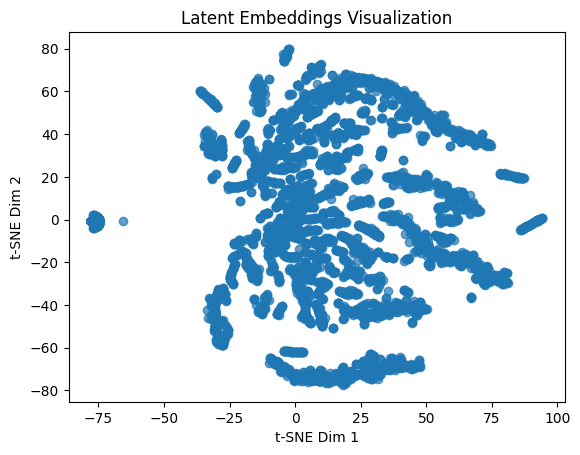

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(latent_embeddings)

# Plot the embeddings
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
plt.title("Latent Embeddings Visualization")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

In [67]:
import numpy as np

# Check for NaN or Inf values
if np.isnan(latent_embeddings).any() or np.isinf(latent_embeddings).any():
    print("Latent embeddings contain NaN or Inf values. Debug your VAE model.")
else:
    print("Latent embeddings are valid.")

# Check for identical embeddings (collapsed space)
print(f"Variance of latent embeddings: {np.var(latent_embeddings, axis=0)}")
if np.var(latent_embeddings) < 1e-6:
    print("Latent embeddings have collapsed (low variance).")
else:
    print("Latent embeddings have sufficient variance.")

Latent embeddings are valid.
Variance of latent embeddings: [4.04838211e-04 0.00000000e+00 0.00000000e+00 2.49833079e-06
 0.00000000e+00 0.00000000e+00 2.19266121e-06 0.00000000e+00
 0.00000000e+00 3.52328527e-07 9.12295434e-07 6.94214425e-04
 8.38184496e-06 6.51252833e-07 0.00000000e+00 8.43268253e-07
 0.00000000e+00 1.13902615e-06 0.00000000e+00 1.64476496e-05
 2.58498812e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.25245968e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.30299121e-07 5.52828737e-07 1.31824607e-09 1.54090014e-06
 0.00000000e+00 0.00000000e+00 4.02879976e-07 6.96154245e-07
 5.14751628e-05 0.00000000e+00 0.00000000e+00 9.88276724e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.73129836e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.56322629e-07 0.0000000

In [14]:
def display_liked_recipes(liked_recipes):
    """
    Display the liked recipes in a table.
    """
    print("Liked Recipes:")
    display(liked_recipes.reset_index(drop=True))  


liked_recipe_indices = [76]
liked_recipes = recipes_df.iloc[liked_recipe_indices][['title', 'categories', 'ingredients']]

display_liked_recipes(liked_recipes)


Liked Recipes:


,title,categories,ingredients
0,Cheddar Chicken Tenders with Wilted Spinach,"['Food Processor', 'Chicken', 'Leafy Green', '...","['2 tablespoons olive oil', '1 1/2 cups Cheez-..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5):
  
    if not isinstance(latent_embeddings, np.ndarray):
        latent_embeddings = latent_embeddings.numpy()

    liked_recipe_indices = [idx for idx in liked_recipe_indices if 0 <= idx < len(latent_embeddings)]
    if not liked_recipe_indices:
        raise ValueError("All indices in liked_recipe_indices are out of bounds.")

    print(f"Valid liked_recipe_indices: {liked_recipe_indices}")

    liked_embeddings = latent_embeddings[liked_recipe_indices]
    print(f"Liked Embeddings Shape: {liked_embeddings.shape}")

    similarity_scores = cosine_similarity(liked_embeddings, latent_embeddings)

    aggregated_scores = np.mean(similarity_scores, axis=0)

    recommended_indices = np.argsort(-aggregated_scores)
    recommended_indices = [idx for idx in recommended_indices if idx not in liked_recipe_indices][:top_n]

    return recommended_indices

In [ ]:
recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)

recommended_recipes_df = recipes_df.iloc[recommended_recipes][['title', 'categories', 'ingredients']]

display_liked_recipes(recommended_recipes_df)

Valid liked_recipe_indices: [76]
Liked Embeddings Shape: (1, 1024)
Liked Recipes:


,title,categories,ingredients
0,Caponatina Toasts,"['Olive', 'Bake', 'Sauté', 'Cocktail Party', '...",['18 (1/8-inch-thick) slices ficelle or baguet...
1,Brussels Sprouts with Golden Onion,"['Onion', 'Vegetable', 'Side', 'Vegetarian', '...",['10 ounces Brussels sprouts (about 2 1/2 cups...
2,Butternut Squash Galette,"['Food Processor', 'Bake', 'Dinner', 'Goat Che...","['1 1/4 cups all-purpose flour', '1 stick cold..."
3,Macadamia and Ginger Stuffing,"['Ginger', 'Side', 'Bake', 'Thanksgiving', 'St...",['6 cups 1/2- to 3/4-inch cubes Hawaiian bread...
4,"Castellane Pasta with Sausage, Peppers, Cherry...","['Herb', 'Onion', 'Pasta', 'Pepper', 'Pork', '...","['1 tablespoon extra-virgin olive oil', '1 pou..."
